<a href="https://colab.research.google.com/github/Anish-AV/Autoencoder/blob/master/Reconstruct_corrupted_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RECONSTRUCTING CORRUPTED TEXT USING AUTOENCODER**

In [1]:
#importing the libraries
import os
import glob
import numpy as np 
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras import backend as K
from sklearn.model_selection import train_test_split
import random
np.random.seed(111)
import tensorflow as tf


Using TensorFlow backend.


In [0]:
#Defining the loss function
def root_mean_squared_error(preds, real):
  return tf.math.sqrt(tf.reduce_mean(tf.square(tf.subtract(preds, real))))



In [3]:
#importing the dataset
train_images=glob.glob("train/*.png")
train_labels=glob.glob("train_cleaned/*.png")
sample_test_img=glob.glob("test/*.png")


X = []
Y = []
test =[]

for img in train_images:
    img = load_img(img,grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(img,grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)

for img in sample_test_img:
    img = load_img(img,grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    test.append(img)

X = np.array(X)
Y = np.array(Y)
test=np.array(test)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)
print("Size of test : ", test.shape)

# Split the dataset into training and validation. Always set the random state!!
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)
print("Total number of training labels: : " , y_train.shape)
print("Total number of validation labels: : " , y_valid.shape)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)
Size of test :  (72, 420, 540, 1)
Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)
Total number of training labels: :  (129, 420, 540, 1)
Total number of validation labels: :  (15, 420, 540, 1)


## **BASIC DENSE MODEL**

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 226800)]          0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               29030528  
_________________________________________________________________
dense_25 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_27 (Dense)             (None, 226800)            29257200  
Total params: 58,320,752
Trainable params: 58,320,752
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
17/17 [==============================] - 0s 23ms/step - loss: 0.9357 - val_loss: 0.7237
Epoch 2/100
1

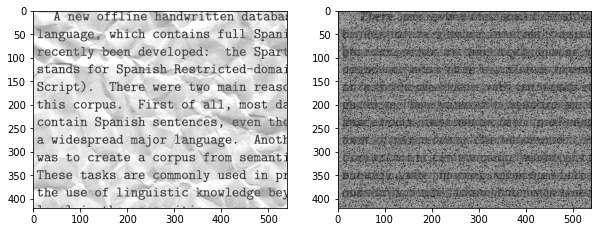

In [0]:
#flattening the images for the dense layer
x_train = np.reshape(X_train, (X_train.shape[0], 226800))
x_valid = np.reshape(X_valid, (X_valid.shape[0], 226800))
#print(x_train.shape)
Y_train = np.reshape(y_train, (y_train.shape[0], 226800))
Y_valid = np.reshape(y_valid, (y_valid.shape[0], 226800))
#print(Y_train.shape)
Test=np.reshape(test,(test.shape[0],226800))

#Building our autoencoder
def build_autoenocder():
    input_img = tf.keras.layers.Input(shape=(226800)) 
    
    #encoder
    x = tf.keras.layers.Dense(128,activation='relu')(input_img)
    encoded = tf.keras.layers.Dense(128,activation='relu')(x)

    #decoder
    x=tf.keras.layers.Dense(128,activation='relu')(encoded)
    decoded = tf.keras.layers.Dense(226800,activation='relu')(x)

    #Building the model
    autoencoder = tf.keras.models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss=root_mean_squared_error)
    return autoencoder
autoencoder = build_autoenocder()
autoencoder.summary()

# Train your model
autoencoder.fit(x_train, Y_train, epochs=100, batch_size=8, validation_data=(x_valid, Y_valid))
predicted_label = autoencoder.predict(Test)

#visualization
rand=random.randint(0,10)
f, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(np.squeeze(test[rand]),cmap='gray')
ax[1].imshow(np.squeeze(predicted_label[rand].reshape(420,540)),cmap='gray')
plt.show()


## **BASIC CNN MODEL**

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 420, 540, 16)      160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 210, 270, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 210, 270, 8)       1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 105, 135, 8)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 105, 135, 8)       584       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 53, 68, 8)         0   

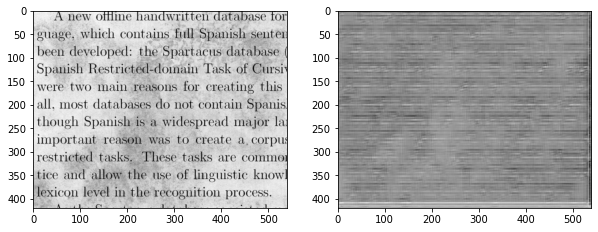

In [0]:
#Datagen= ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True)

#Building our autoencoder
def build_autoenocder():
    input_img = tf.keras.layers.Input(shape=(420, 540, 1))
    
    #encoder
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    #decoder
    x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    #Building the model
    autoencoder = tf.keras.models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss=root_mean_squared_error)
    return autoencoder
autoencoder = build_autoenocder()
autoencoder.summary()

# Train your model
autoencoder.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_valid, y_valid))
#autoencoder.fit_generator(Datagen.flow(X_train, y_train, batch_size=8),steps_per_epoch=len(x_train) / 8, validation_data=(X_valid, y_valid), epochs=100)
predicted_label = autoencoder.predict(test)

#visualization
rand=random.randint(0,10)
f, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(np.squeeze(test[rand]),cmap='gray')
ax[1].imshow(np.squeeze(predicted_label[rand].reshape(420,540)),cmap='gray')
plt.show()

## **CNN COMPLEX MODEL 1**

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 420, 540, 16)      416       
_________________________________________________________________
batch_normalization_9 (Batch (None, 420, 540, 16)      64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 210, 270, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 210, 270, 8)       3208      
_________________________________________________________________
batch_normalization_10 (Batc (None, 210, 270, 8)       32        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 105, 135, 8)       0   

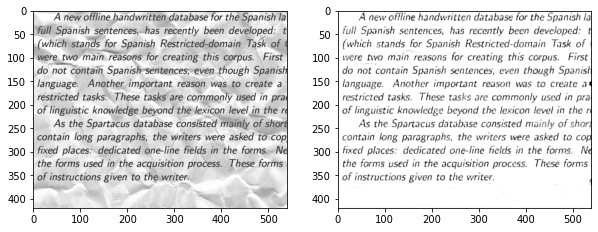

In [0]:
#Datagen= ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True)
#Building our autoencoder
def build_autoenocder():
    input_img = tf.keras.layers.Input(shape=(420, 540, 1)) 
    
    #encoder
    x = tf.keras.layers.Conv2D(16, (5, 5), activation='relu', padding='same')(input_img)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    #decoder
    x = tf.keras.layers.Conv2D(8, (5, 5), activation='relu', padding='same')(encoded)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
rand=random.randint(0,10)
f, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(np.squeeze(test[rand]),cmap='gray')
ax[1].imshow(np.squeeze(predicted_label[rand].reshape(420,540)),cmap='gray')
plt.show()
    #Building the model
    autoencoder = tf.keras.models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss=root_mean_squared_error)
    return autoencoder
autoencoder = build_autoenocder()
autoencoder.summary()

# Train your model
#autoencoder.fit_generator(Datagen.flow(X_train, y_train, batch_size=8),steps_per_epoch=len(x_train) / 8, validation_data=(X_valid, y_valid), epochs=100)
autoencoder.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_valid, y_valid))
predicted_label = autoencoder.predict(test)

#visualization
rand=random.randint(0,10)
f, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(np.squeeze(test[rand]),cmap='gray')
ax[1].imshow(np.squeeze(predicted_label[rand].reshape(420,540)),cmap='gray')
plt.show()

## **CNN COMPLEX MODEL 2**

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 420, 540, 16)      416       
_________________________________________________________________
batch_normalization_18 (Batc (None, 420, 540, 16)      64        
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 420, 540, 8)       3208      
_________________________________________________________________
batch_normalization_19 (Batc (None, 420, 540, 8)       32        
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 420, 540, 8)       1608      
_________________________________________________________________
batch_normalization_20 (Batc (None, 420, 540, 8)       32  

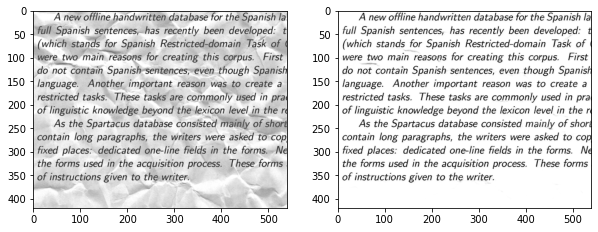

In [8]:

#Defining the autoencoder architecture
def build_autoenocder():
    input_img = tf.keras.layers.Input(shape=(420, 540, 1)) 
    
    #encoder
    x = tf.keras.layers.Conv2D(16, (5, 5), activation='relu', padding='same')(input_img)
    x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)


    #decoder
    x = tf.keras.layers.Conv2D(8, (5, 5), activation='relu', padding='same')(encoded)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    

    autoencoder = tf.keras.models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return autoencoder
autoencoder = build_autoenocder()
autoencoder.summary()


#training the model
autoencoder.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_valid, y_valid))
#Predictions
predict=autoencoder.predict(test)

#Visualization
rand=random.randint(0,10)
f, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(np.squeeze(test[rand]),cmap='gray')
ax[1].imshow(np.squeeze(predict[rand].reshape(420,540)),cmap='gray')
plt.show()